In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Setup.
!pip install -q wordcloud
import wordcloud

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger') 

import pandas as pd
import matplotlib.pyplot as plt
import io
import unicodedata
import numpy as np
import re
import string
import os
import json
import collections
import PIL
import wordcloud
import seaborn as sns
import bz2
from PIL import Image
from ast import literal_eval
import scipy.stats as stats
from nltk import FreqDist
from matplotlib import colors

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


## **Data preprocessing**
We selected the data from New York Times as the study corpus because of its great influence all around the world and its multiple well-classified categories. Quotations of New York Times were selected from data spanning the years 2015 to 2020 and preprocessed as follows: 
* We annotated the gender, nationality, occupation, and political party of speakers (as indicated in the dataframe below), and if there were multiple attributions, we utilized the gender and political party of the first speaker for analysis (columns 'first speaker gender' and 'first speaker party').
* We iterated over all of the quotations, tokenized them and added them up.(column "all_words_counts")
* We introduced a list of approximate 100 feminine-masculine word pairings and counted the number and recorded the feminine and masculine words existing in each quotation.(columns "male_word_num","male_words","female_word_num","female_words")
* We introduced another list of 700 words generated by a relative research where volunteers were engaged to evaluate the 700 words (1$<$score$<$7) based on their relation to female or male (For example, if word "woman" is considered more related to female, then the score will be closer to 1, otherwise it will be closer to 7). Then we counted all the words existing in all quotations and computed the sum or mean of the score for analysis.(columns: "politician_word_num", "politician_words", "sum_score")
* Following these data preprocessing steps, the data were stored in csv format for further usage.

In [3]:
# Read the data that we preprocessed previously.
df_2015 = pd.read_csv('/content/drive/Shareddrives/ADA/Quotes_with_people/caches/nytime_2015_with_people_with_both_words_1.csv')
df_2016 = pd.read_csv('/content/drive/Shareddrives/ADA/Quotes_with_people/caches/nytime_2016_with_people_with_both_words_1.csv')
df_2017 = pd.read_csv('/content/drive/Shareddrives/ADA/Quotes_with_people/caches/nytime_2017_with_people_with_both_words_1.csv')
df_2018 = pd.read_csv('/content/drive/Shareddrives/ADA/Quotes_with_people/caches/nytime_2018_with_people_with_both_words_1.csv')
df_2019 = pd.read_csv('/content/drive/Shareddrives/ADA/Quotes_with_people/caches/nytime_2019_with_people_with_both_words_1.csv')
df_2020 = pd.read_csv('/content/drive/Shareddrives/ADA/Quotes_with_people/caches/nytime_2020_with_people_with_both_words_1.csv')
# Data from 2016 serves as an example here.
df_2016.head(3)

,Unnamed: 0,index,Unnamed: 0.1,Unnamed: 0.1.1,index_label,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,category,Gender,Nationality,Occupation,Party,male_word_num,female_word_num,male_words,female_words,year_month,first_speaker_gender,politician_word_num,politician_words,sum_score,all_words_counts,first_speaker_party
0,0,10,10,10,10,2016-06-30-006806,He is hoping that the playwrights and actors h...,Ben Wizner,['Q21498061'],2016-06-30 00:00:00,3,"[['Ben Wizner', '0.8811'], ['None', '0.1063'],...",['http://www.nytimes.com/2016/07/01/theater/ed...,E,uncategorized,[['male']],[['United States of America']],"[['lawyer', 'writer', 'civil rights advocate']]",[['No data']],2,0,"['he', 'actors']",[],2016-06,male,1,['people'],4.185185,29,No data
1,1,11,11,11,11,2016-05-27-031063,He was holding my hands until the end,Sunao Tsuboi,['Q11425715'],2016-05-27 02:29:00,139,"[['Sunao Tsuboi', '0.5736'], ['None', '0.2992'...",['http://www.abqjournal.com/781824/obamas-hug-...,E,politics,[['male']],[['Japan']],[['educator']],[['No data']],1,0,['he'],[],2016-05,male,0,[],0.000000,8,No data
2,2,17,17,17,17,2016-09-07-040636,I just kept pushing her back and tried to make...,Caroline Wozniacki,['Q30767'],2016-09-07 00:00:00,22,"[['Caroline Wozniacki', '0.8121'], ['None', '0...",['http://asia.eurosport.com/tennis/wozniacki-d...,E,sports,[['female']],[['Denmark']],[['tennis player']],[['No data']],0,2,[],"['her', 'her']",2016-09,female,0,[],0.000000,26,No data


## **Useful functions for data visualization**
Here we have several functions for data visualization:
* **func_visualization_0**:
It gives two wordcloud figures showing the most frequently-used feminine words and masculine words.
* **func_visualization_1**: 
It focuses on the analysis on an overall level and it contains 3 sets of figures. 
 * The first set includes two lineplots illustrating how the count and ratio of masculine and feminine words change as time change. 
 * The second set includes two barplots illustrating how feminine words and masculine words are used differently in different categories of the newspaper.
 * The third set includes two pieplots illustrating if people of different genders have a preference for feminine/masculine words.
* **func_visualization_2**: 
This visualization illustrates the most frequently-used 30 feminine/masculine words by the sum of their counts from 2015 to 2020.
* **func_visualization_3**:
This visualization focuses on the analysis on a party level and has 2 sets of figures.
 * The first set includes all words spoken by Republican and Democratic Party respectively and how many feminine/masculine words detected in Republican quotations and Democratic quotations.
 * The second set reflects the composition of feminine words and masculine words in all words spoken by the Republican and Democratic Party.

* **func_visualization_4**: 
This visualization tries to reflect the gender composition of speakers and how different genders use the two types of words in Republican and Democratic Party. It generates two figures.

* **func_visualization_5**: 
This visualization has two barplots and shows the gender composition of the top 50 speakers with the most sum of spoken words in Republican and Democratic Party. 

* **func_visualization_6**
This visualization has two boxplots showing the score distribution difference on gender and party level. 

More detailed explanation can be found in the following parts.

In [4]:
# Functions for visualization

def sum_words(df):
  """
  Aggregate all the female words and male words used into two lists.
  """
  female_wordlist = []
  male_wordlist = []
  female_df = df[df['female_word_num']!=0].reset_index()
  male_df = df[df['male_word_num']!=0].reset_index()
  for line in range(female_df.shape[0]):
    female_wordlist = female_wordlist + literal_eval(female_df['female_words'][line])
  for line in range(male_df.shape[0]):
    male_wordlist = male_wordlist + literal_eval(male_df['male_words'][line])
  return female_wordlist, male_wordlist

def visualization_0(df):
  """
  Count the times feminine words and masculine words are used.
  Visualize the usage frequency by wordcloud plots.
  """
  female_wordlist, male_wordlist = sum_words(df)
  fdist_female = FreqDist(female_wordlist)
  fdist_male = FreqDist(male_wordlist)
  mask_female = np.array(Image.open('/content/drive/Shareddrives/ADA/Quotes_with_people/caches/female.png'))
  mask_male = np.array(Image.open('/content/drive/Shareddrives/ADA/Quotes_with_people/caches/male.png'))
  wc_female = wordcloud.WordCloud(
        mask = mask_female,
        max_words = 200,
        font_path = '/content/drive/Shareddrives/ADA/Quotes_with_people/caches/CALIBRI.TTF',
        max_font_size = 200,
        background_color = 'white',
        colormap = 'RdYlGn',
        scale = 20)
  
  wc_male = wordcloud.WordCloud(
      mask = mask_male,
      max_words = 200,
      font_path = '/content/drive/Shareddrives/ADA/Quotes_with_people/caches/CALIBRI.TTF',
      max_font_size = 200,
      background_color = 'white',
      scale = 20,
      colormap = 'tab20c')

  fig = plt.figure(figsize=(10,8))
  plt.subplot(1,2,1)
  wc_female.generate_from_frequencies(fdist_female)
  image_colors = wordcloud.ImageColorGenerator(mask_female)
  plt.imshow(wc_female)
  plt.axis('off')

  plt.subplot(1,2,2)
  wc_male.generate_from_frequencies(fdist_male)
  image_colors = wordcloud.ImageColorGenerator(mask_male)
  plt.imshow(wc_male)
  plt.axis('off')


def visualization_1(dataframe_processed, big_title = None):
  """
  2 lineplots visualize how count and ratio of masculine and feminine words change as time change.
  2 barplots illustrate how feminine and masculine words are used in different categories of the newspaper.
  4 pieplots show if people of different genders have a preference for feminine/masculine words.
  """
  # Part1: analyze the male/female words as time changes
  df_male = dataframe_processed[dataframe_processed['male_word_num']!=0].groupby('year_month').sum()['male_word_num']
  df_female = dataframe_processed[dataframe_processed['female_word_num']!=0].groupby('year_month').sum()['female_word_num']
  df_ratio = df_male/df_female
  fig = plt.figure(figsize=(8,6))

  ## figure1-1 male/female counts change
  plt.subplot(2,1,1)
  plt.xlabel('time')
  plt.ylabel('number of words')
  plt.plot(df_male,label="male",color = '#bacfea')
  plt.plot(df_female,label="female",color = '#f9c1ab')
  plt.legend(loc='best')
  plt.xticks(rotation=20)
  plt.title('How does masculine words/feminine words counts change as time goes?',fontsize=11)

  ## figure1-2 ratio change
  plt.subplot(2,1,2)
  plt.xlabel('time')
  plt.ylabel('male/female words')
  plt.xticks(rotation=20)
  plt.plot(df_ratio, color = '#89b4eb')
  plt.title('How about the ratio?',fontsize=11)
  plt.tight_layout()
  plt.subplots_adjust(top=0.9)
  plt.suptitle(big_title,fontweight ="bold")
  

  ## Part2: find out the constitution of masculine and feminine words in different categories
  df2_1 = dataframe_processed[dataframe_processed['male_word_num']!=0].groupby('category').sum()['male_word_num']
  df2_2 = dataframe_processed[dataframe_processed['female_word_num']!=0].groupby('category').sum()['female_word_num']
  df2 = pd.concat([df2_1, df2_2],axis=1).fillna(0)

  ## figure2-1 masculine/feminine words counted in different categories
  plt.figure(figsize=(8,5))
  plt.subplot(1,2,1)
  x_21 = range(df2.shape[0])
  y_21 = [i+0.4 for i in x_21]
  ticks_21 = [i+0.2 for i in x_21]
  label_list = df2.T.columns
  plt.bar(x_21, height = df2['male_word_num'], width=0.4, alpha=0.8, label='male',color='#bacfea')
  plt.bar(y_21, height = df2['female_word_num'], width=0.4, alpha=0.8, label='female',color='#f9c2a9')
  plt.xlabel('category')
  plt.xticks(ticks_21, label_list, rotation=90)
  plt.title('In different categories,\n how are two types of words used?',fontsize=11)
  plt.legend() 

  ## figure2-2 In different categories, which type of words is preferred: masculine or feminine
  plt.subplot(1,2,2)
  bottom_y = df2['male_word_num']/(df2['female_word_num']+df2['male_word_num'])
  plt.ylim((-0.3,1.1))
  plt.bar(x_21,height=bottom_y, width=0.6, alpha=0.8, label='masculine words',color='#bacfea')
  plt.bar(x_21, height=1-bottom_y ,width=0.6, alpha=0.8, bottom=bottom_y, label='feminine words',color='#f9c2a9')
  plt.ylabel('percentage')
  plt.xlabel('category')
  plt.xticks(x_21, label_list, rotation=90)
  plt.legend()
  plt.title('In different categories,\nwhich type of words is preferred?',fontsize=11)
  plt.tight_layout()

  # Part3: analyze the gender of speakers

  ## figure3-1 Who contributes to the use of masculine words and is there any preference?
  df3 = dataframe_processed.groupby('first_speaker_gender').sum()[['male_word_num','female_word_num']].sort_values(by='male_word_num',ascending=False)
  label1 = ['male','female','others']
  label2 = ['masculine','feminine']
  plt.figure(figsize=(8,8))
  plt.subplot(2,2,1)
  plt.pie([df3['male_word_num']['male'],df3['male_word_num']['female'],df3['male_word_num'][2:].sum()],labels= label1,colors=['#bacfea','#fac0ab','#e0e0e0'], wedgeprops={'alpha':0.7}, autopct="%.1f%%")
  plt.title('Who contributes to the use of masculine words?',fontsize=11)
  plt.subplot(2,2,2)
  plt.pie([df3['female_word_num']['male'],df3['female_word_num']['female'],df3['female_word_num'][2:].sum()],labels= label1,colors=['#bacfea','#fac0ab','#e0e0e0'],wedgeprops={'alpha':0.7},autopct="%.1f%%")
  plt.title('Who contributes to the use of feminine words?',fontsize=11)
  plt.subplot(2,2,3)
  plt.pie([df3['male_word_num']['male'],df3['female_word_num']['male']],labels= label2,colors=['#bacfea','#fac0ab'], wedgeprops={'alpha':0.7},autopct="%.1f%%")
  plt.title('Feminine or masculine?\n Males prefer to use:',fontsize=11)
  plt.subplot(2,2,4)
  plt.pie([df3['male_word_num']['female'],df3['female_word_num']['female']],labels= label2, colors=['#bacfea','#fac0ab'],wedgeprops={'alpha':0.7},autopct="%.1f%%")
  plt.title('Feminine or masculine?\n Females prefer to use:',fontsize=11)
  plt.tight_layout()

def _barplot(ax1, df):
  """
  1 barplot.
  Compute the most frequently-used feminine words and masculine words.
  Visualize the counts of words by a barplot.
  """
  female_df, male_df = sum_words(df)
  fdist_female = FreqDist(female_df)
  fdist_male = FreqDist(male_df)
  ax1_sub = ax1.twinx()
  ax1.barh(range(30),[-fdist_female.most_common(30)[29-i][1] for i in range(30)],
      tick_label=[fdist_female.most_common(30)[29-i][0] for i in range(30)],color='#fac1a9',)
  ax1_sub.barh(range(30),[fdist_male.most_common(30)[29-i][1] for i in range(30)],
      tick_label=[fdist_male.most_common(30)[29-i][0] for i in range(30)],color='#bacfea')
  ax1.spines['left'].set_visible(False)
  ax1_sub.spines['left'].set_visible(False)
  ax1.spines['right'].set_visible(False)
  ax1_sub.spines['right'].set_visible(False)
  ax1.spines['top'].set_visible(False)
  ax1_sub.spines['top'].set_visible(False)
  plt.xlabel('absolute count')
  plt.tight_layout()

def visualization_2(dfs):
  """
  6 barplots using function _barplot(ax1, df)
  Visualize and compare the data between year 2015 and year 2020.
  """
  fig, (axs) = plt.subplots(1,len(dfs),figsize=(3*len(dfs),6))
  for i in range(len(dfs)):
    _barplot(axs[i], dfs[i])
    plt.title(i+2015)

def visualization_3(df, big_title = None):
  """
  1 barplot visualizes all words spoken by Republican and Democratic Party respectively.
  1 barplot shows how many feminine/masculine words detected in Republican quotations and Democratic quotations.
  2 pieplots reflect the composition of feminine words and masculine words in all words spoken by the Republican and Democratic Party.
  """
  # select the democratic party and republican party rows
  df= df.query("first_speaker_party == 'Democratic Party**' or first_speaker_party == 'Republican Party**'")
  # how many words do democratic party and republican party say and how is the composition of feminine/masculine words
  df1 = df.groupby('first_speaker_party').sum()[['male_word_num','female_word_num','politician_word_num','all_words_counts']]
  plt.figure(figsize = (8,7))

  plt.subplot(2,2,1)
  plt.bar(df1.index, df1.all_words_counts,width=0.5,color='#bacfea')
  plt.ylabel('word counts')
  plt.title('all words counts')

  plt.subplot(2,2,2)
  plt.bar(df1.index, df1.male_word_num, width=0.5,color = '#bacfea')
  plt.bar(df1.index, df1.female_word_num, width=0.5,
              bottom=df1.male_word_num,color='#fac1a9')

  for i in range(2):
    plt.text(df1.index[i], (df1.male_word_num[i]+df1.female_word_num[i])+0.05, '%.0f' %(df1.male_word_num[i]+df1.female_word_num[i]), ha='center', va= 'bottom')
    plt.text(df1.index[i], (df1.male_word_num[i])+0.05, '%.0f%%'%(df1.male_word_num[i]/(df1.male_word_num[i]+df1.female_word_num[i])*100) ,ha='center', va= 'bottom')
  plt.ylabel('word counts')
  plt.title('masculine/feminine words composition')
  plt.legend(['masculine words','feminine words'], loc=0)

  df1['male_word_ratio'] = df1['male_word_num']/df1['all_words_counts']
  df1['female_word_ratio'] = df1['female_word_num']/df1['all_words_counts']
  plt.subplot(2,2,3)
  labels = ['masculine words','feminine words','other words']
  x_dem = [df1['male_word_ratio']['Democratic Party**'],df1['female_word_ratio']['Democratic Party**']]
  x_dem.append(1-x_dem[1]-x_dem[0])
  plt.pie(x_dem,labels = labels, colors = ['#bacfea','#fac1a9','#e0e0e0'], autopct='%1.1f%%')
  plt.title('\nDemocratic Party')

  plt.subplot(2,2,4)
  x_rep = [df1['male_word_ratio']['Republican Party**'],df1['female_word_ratio']['Republican Party**']]
  x_rep.append(1-x_rep[1]-x_rep[0])
  plt.pie(x_rep,labels = labels, colors = ['#bacfea','#fac1a9','#e0e0e0'], autopct='%1.1f%%')
  plt.title('\nRepublican Party')
  plt.tight_layout()
  plt.subplots_adjust(top=0.9)
  plt.suptitle(big_title,fontweight ="bold")

def visualization_4(df,big_title=None):
  """
  1 barplot shows the number of female/male speakers in two Parties.
  1 barplot shows how females/males use the feminine/masculine words in two Parties.
  """
  df= df.query("first_speaker_party == 'Democratic Party**' or first_speaker_party == 'Republican Party**'")
  df_2 = df.groupby(['first_speaker_party','first_speaker_gender']).sum()[['male_word_num','female_word_num','all_words_counts']]

  plt.figure(figsize=(8,4))
  # Compute all words spoken by female or male speakers from different Parties.
  plt.subplot(1,2,1)
  male_y = [df_2['all_words_counts']['Democratic Party**']['male'],df_2['all_words_counts']['Republican Party**']['male']]
  female_y = [df_2['all_words_counts']['Democratic Party**']['female'],df_2['all_words_counts']['Republican Party**']['female']]
  labels = ['Democratic Party','Republican Party']
  x = np.arange(len(labels))
  width = 0.4
  plt.bar(x-width/2,male_y,width,label ='male speaker',color ='#bacfea')
  plt.bar(x+width/2, female_y, width,label = 'female speaker', color='#f9c2a9')
  plt.xticks(x,labels=labels)
  plt.ylabel('number of words')
  plt.legend()

  # Compute words composition of female speakers and male speakers in different parties
  plt.subplot(1,2,2)
  male_speak_female_words = [df_2['female_word_num']['Democratic Party**']['male'],df_2['female_word_num']['Republican Party**']['male']]
  male_speak_male_words = [df_2['male_word_num']['Democratic Party**']['male'],df_2['male_word_num']['Republican Party**']['male']]
  female_speak_female_words = [df_2['female_word_num']['Democratic Party**']['female'],df_2['female_word_num']['Republican Party**']['female']]
  female_speak_male_words = [df_2['male_word_num']['Democratic Party**']['female'],df_2['male_word_num']['Republican Party**']['female']]
  labels = ['Democratic Party','Republican Party']
  x = np.arange(len(labels))
  width = 0.4
  plt.bar(x-width/2,male_speak_female_words,width,label ='males speak female words',color ='#bacfea')
  plt.bar(x-width/2,male_speak_male_words,width,label ='males speak male words',bottom=male_speak_female_words,color ='#89b4eb')
  plt.bar(x+width/2, female_speak_female_words, width,label = 'females speak female words', color='#f9c2a9')
  plt.bar(x+width/2, female_speak_male_words, width,label = 'females speak male words',bottom=female_speak_female_words, color='#fa9b73')
  for i in range(2):
    plt.text(x[i]-width/2, male_speak_female_words[i]+0.05, '%.0f%%'%(male_speak_female_words[i]/(male_speak_female_words[i]+male_speak_male_words[i])*100), ha='center', va= 'bottom')
    plt.text(x[i]+width/2, female_speak_female_words[i]+0.05, '%.0f%%'%(female_speak_female_words[i]/(female_speak_female_words[i]+female_speak_male_words[i])*100), ha='center', va= 'bottom')
    plt.text(x[i]-width/2, male_speak_female_words[i]+male_speak_male_words[i]+0.05, '%.0f'%(male_speak_female_words[i]+male_speak_male_words[i]),ha='center', va= 'bottom')
    plt.text(x[i]+width/2, female_speak_female_words[i]+female_speak_male_words[i]+0.05, '%.0f'%(female_speak_female_words[i]+female_speak_male_words[i]),ha='center', va= 'bottom')
  plt.xticks(x,labels=labels)
  plt.ylabel('number of words')
  plt.legend(loc=0)
  plt.tight_layout()
  plt.subplots_adjust(top=0.9)
  plt.suptitle(big_title,fontweight ="bold")

def count_speaker_gender(df):
  """
  Count the number of female/male speakers in every 5 speakers among the top 50 speakers.
  For example, among the first 1-5 speakers: there are 4 males and 1 female.
  """
  female_speaker_counts = []
  male_speaker_counts = []
  df_to_sort = df.groupby(['speaker','first_speaker_gender','first_speaker_party']).sum().sort_values(by='all_words_counts',ascending = False)
  for i in range(10):
    if len(df_to_sort[5*i:5*i+5].groupby('first_speaker_gender').count().index)==2:
      female_speaker_counts.append(df_to_sort[5*i:5*i+5].groupby('first_speaker_gender').count()['index']['female'])
      male_speaker_counts.append(df_to_sort[5*i:5*i+5].groupby('first_speaker_gender').count()['index']['male'])
    elif df_to_sort[5*i:5*i+5].groupby('first_speaker_gender').count().index[0] == 'female':
      female_speaker_counts.append(5)
      male_speaker_counts.append(0)
    else:
      female_speaker_counts.append(0)
      male_speaker_counts.append(5)
  ratios = []
  for i in range(len(female_speaker_counts)):
    ratios.append(male_speaker_counts[i]/(male_speaker_counts[i]+female_speaker_counts[i]))
  return female_speaker_counts, male_speaker_counts, ratios

def visualization_5(df, big_title = None):
  """
  Visualize the different gender composition in every 5 speakers among the top 50 speakers in two Parties.
  """
  df1 = df.query("first_speaker_party == 'Democratic Party**' or first_speaker_party == 'Republican Party**'")
  df2 = df.query("first_speaker_party == 'Democratic Party**'")
  df3 = df.query("first_speaker_party == 'Republican Party**'")
  # Plot the female_speaker/male_speaker number in the 50th most "influential" speakers (5 as an interval)
  fe_num, ma_num, _ = count_speaker_gender(df1)
  fe_num_d, ma_num_d, _ = count_speaker_gender(df2)
  fe_num_r, ma_num_r, _ = count_speaker_gender(df3)
  plt.figure(figsize = (7,5))
  plt.subplot(2,1,1)
  x = ['1-5','6-10','11-15','16-20','21-25','26-30','31-35','35-40','41-45','46-50']
  plt.bar(x, fe_num_d, label = 'female speaker',color = '#fac1a9')
  plt.bar(x, ma_num_d, bottom = fe_num_d, label = 'male speaker',color = '#bacfea')
  plt.ylim((-0.5,5.5))
  plt.xlim((-1,13.5))
  plt.title('gender composition in Democratic Party')
  plt.legend(loc = 7)
  plt.subplot(2,1,2)
  plt.bar(x, fe_num_r, label = 'female speaker',color = '#fac1a9')
  plt.bar(x, ma_num_r, bottom = fe_num_r, label = 'male speaker',color = '#bacfea')
  plt.ylim((-0.5,5.5))
  plt.xlim((-1,13.5))
  plt.title('gender composition in Republican Party')
  plt.legend(loc = 7)
  plt.tight_layout()
  plt.subplots_adjust(top=0.9)
  plt.suptitle(big_title,fontweight ="bold")

def visualization_6(df, big_title):
  """
  2 boxplots visualize the distribution of scores achieved by speakers of two Parties.
  """
  df = df[df['politician_word_num']!=0].copy()
  df['average_score'] = df['sum_score']/df['politician_word_num']
  df1 = df.query('first_speaker_gender =="female" or first_speaker_gender =="male"')
  plt.figure(figsize = (8,4))
  plt.subplot(1,2,1)
  # plot the distribution of scores of different genders
  sns.boxplot(x='first_speaker_gender', y='average_score', data = df1, palette = ['#fac1a9','#bacfea'], width=0.3)
  plt.xlabel('gender of speaker')
  plt.ylabel('average score (1-7)')
  plt.title('score distribution on different gender')
  # plot the distribution of scores of different parties
  df2 = df.query("first_speaker_party == 'Democratic Party**' or first_speaker_party == 'Republican Party**'")
  plt.subplot(1,2,2)
  sns.boxplot(x='first_speaker_party', y='average_score',data =df2,palette = ['#89b4eb','#fa9b73'],width=0.3)
  plt.xlabel('party of speaker')
  plt.ylabel('average score (1-7)')
  plt.title('score distribution on different parties')
  plt.tight_layout()
  plt.subplots_adjust(top=0.87)
  plt.suptitle(big_title,fontweight ="bold")

## **1. Introduction**
Following Emma Watson's speech at the United Nations, the public is becoming more aware of gender inequality. Despite the fact that several proposals have been made to address gender imbalance, it is still unclear if the situation has improved.

The quote database provides us with an excellent corpus to examine the subject. The New York Times was chosen as the research corpus for this section owing to its widespread effect and a variety of other factors. We first choose about 100 pairs of feminine and masculine phrases (for example, actress - actor, she - he) and count how many times these feminine/masculine words appear in quotations from the New York Times from 2015 to 2020. Then we look at the gender of the speakers to see if gender has an impact on whether speakers choose feminine or masculine terms. We also compare the frequency of masculine/feminine words usage in different fields and different political parties and achieve quite interesting results.

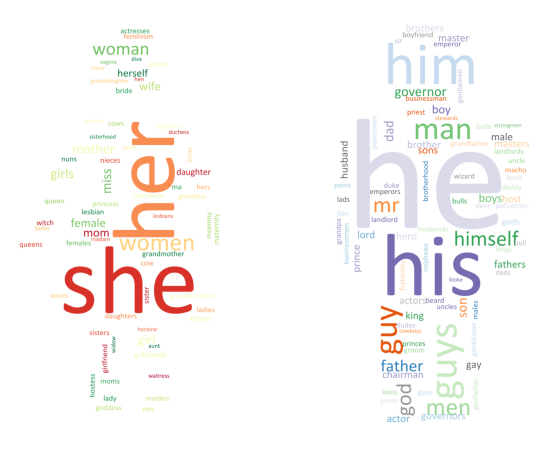

In [5]:
# Introduction: the most frequently-used feminine/masculine words
visualization_0(df_2016)

## **2. Statistics**
**Note**: Our analysis is based on data from 2015 to 2020.

### **2.1. Language**
#### **How masculine/feminine words counts and ratio change as time goes?**
In the first two line plots, we visualize the change of counts and ratio of masculine/feminine words throughout a year (2015-2020). From these line plots, on one hand, we can observe an almost random change in the counts of masculine and feminine words and masculine/feminine ratio, and on the other hand, most of the masculine/feminine ratios are over 1, which indicates a higher usage of masculine words than feminine words.
Next, we examine the masculine/feminine words usage in different categories, as well as the gender of speakers to find out possible explanations of this intriguing phenomenon.

#### **How masculine/feminine words are used in different categories?**
Quotations are categorized into different fields and the masculine/feminine words ratio is computed in every field. For most fields, the masculine words percentage is mostly higher than 50% and the phenomenon is commonly observed in dataset from 2015 to 2020. We also note that for hit topics (with highest total word usage) such as politics and sports, the masculine/feminine words usage is always far higher than 0.5 while for topics like real-estate masculine/feminine words ratio is always not that high (0.5~0.6). 

### **2.2. Language And Gender**
#### **Who contributes to the use of masculine/feminine words?**
The information of the speakers is then incorporated for comparison, and speakers of masculine and feminine terms are classified by gender, with the findings shown in the four pie charts. From the first 2 pie plots, we can see that for the usage of both masculine and feminine words, male speakers have more contribution than female speakers. By comparing the composition of words used by males and females, we can see that males prefer to use masculine words while females use almost equally masculine words and feminine words. So far, we seem to be able to partly explain why masculine words are used more than feminine words: males speak “more”, or in other words, males have more opportunity to speak than females, and meanwhile, males tend to speak much more masculine words than feminine words.

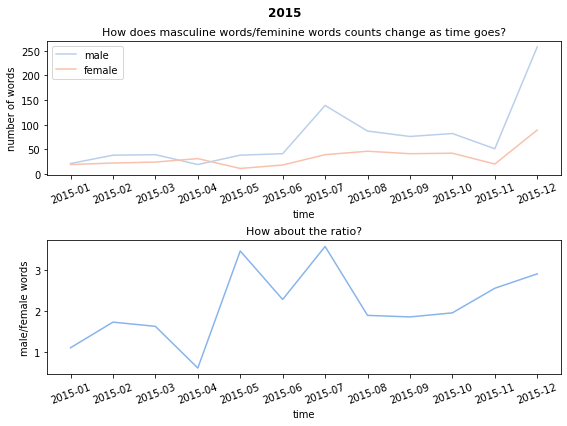

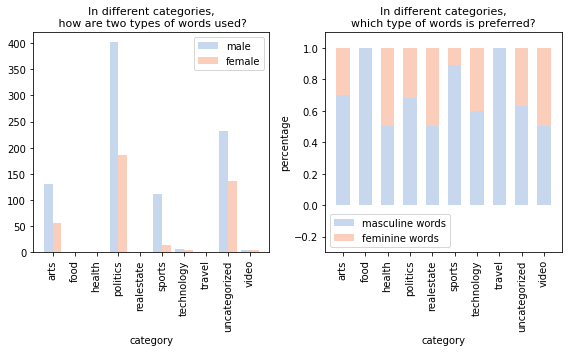

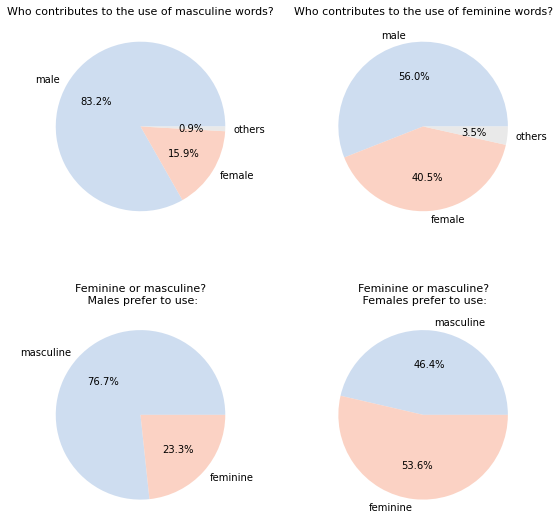

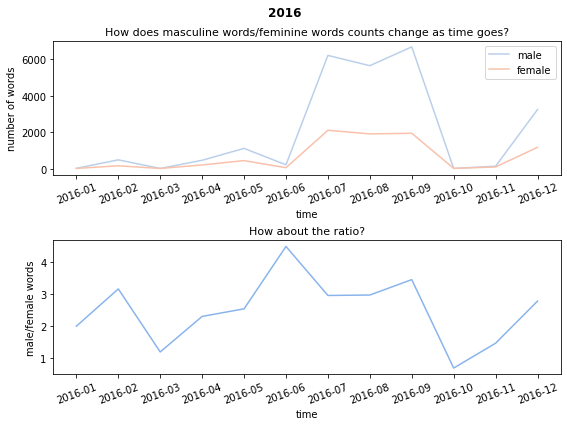

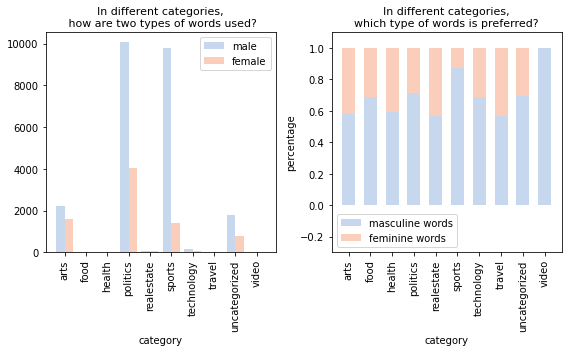

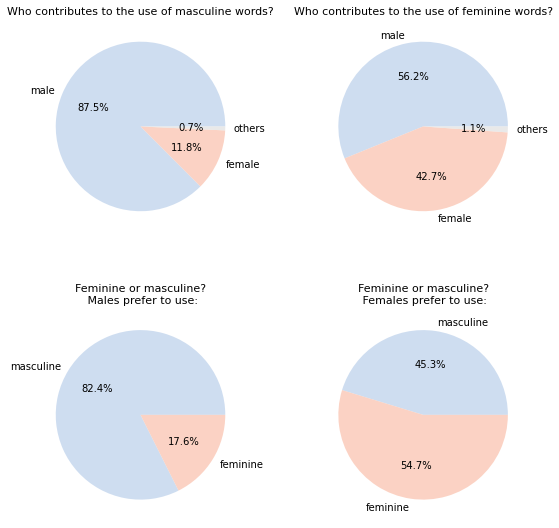

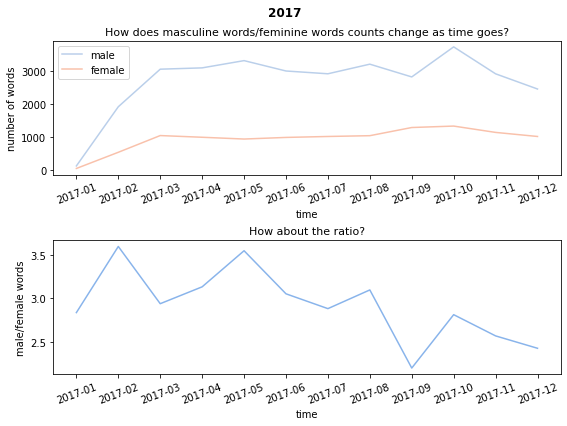

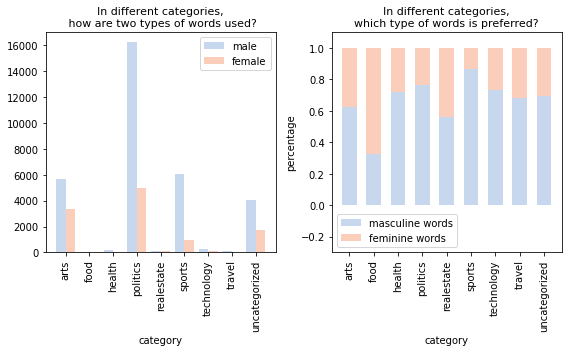

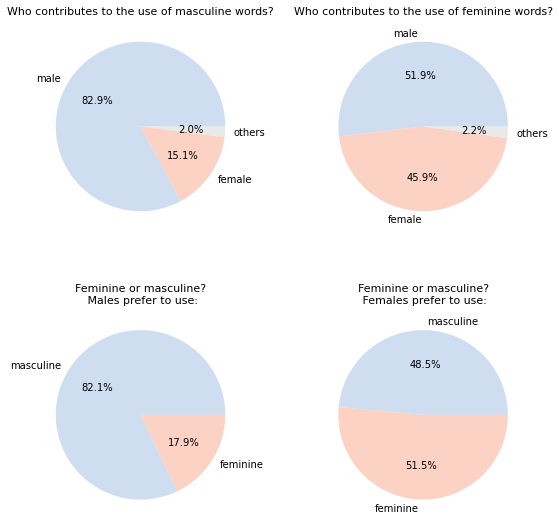

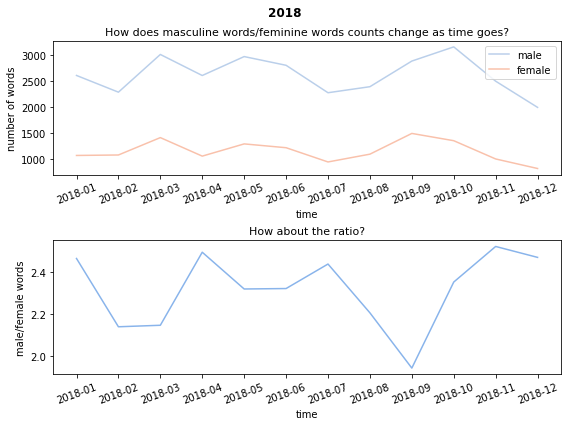

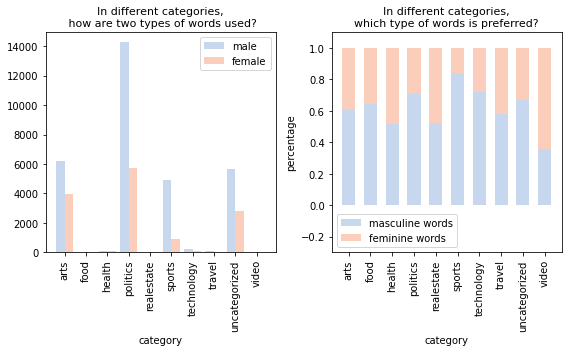

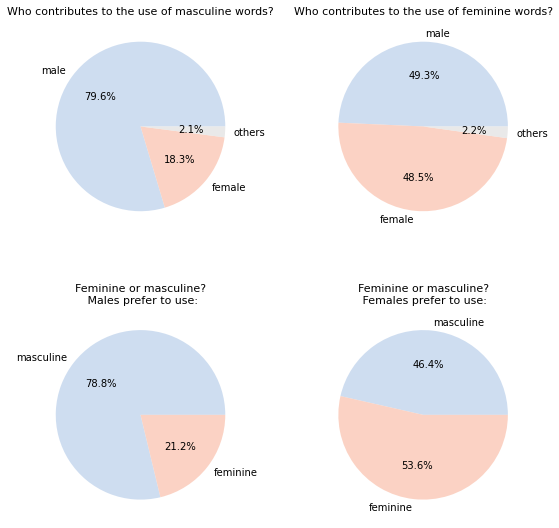

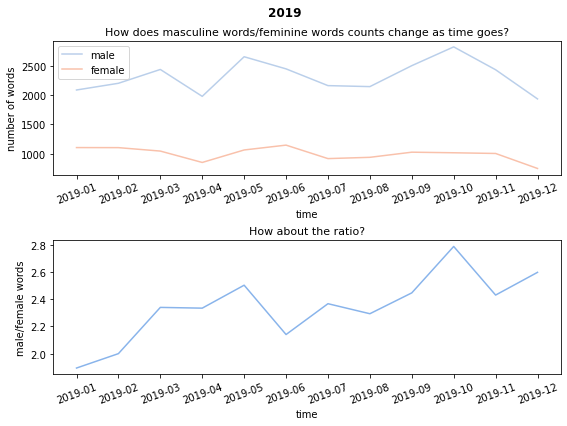

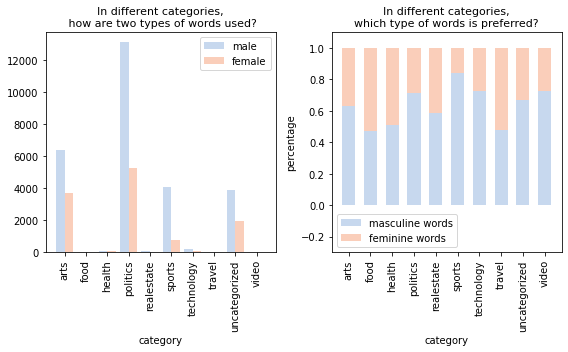

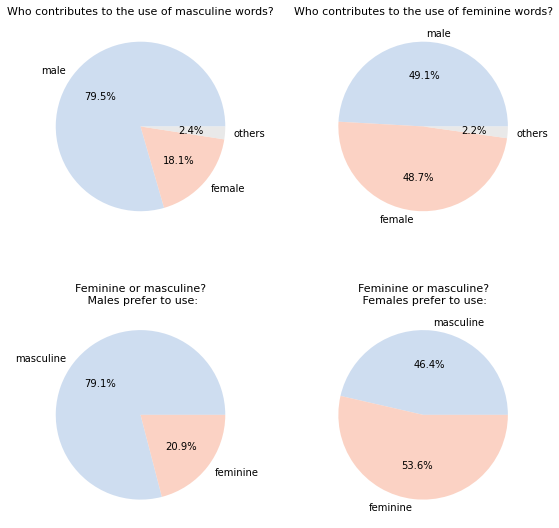

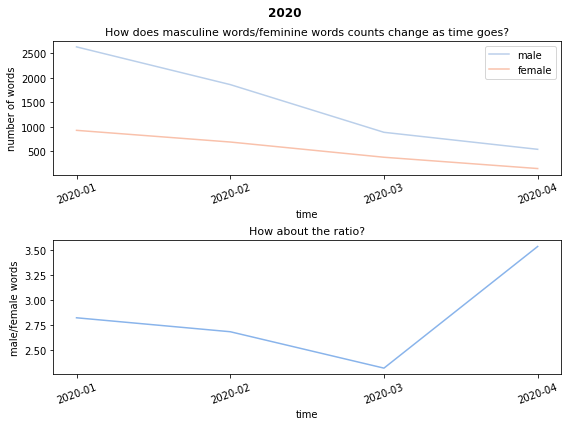

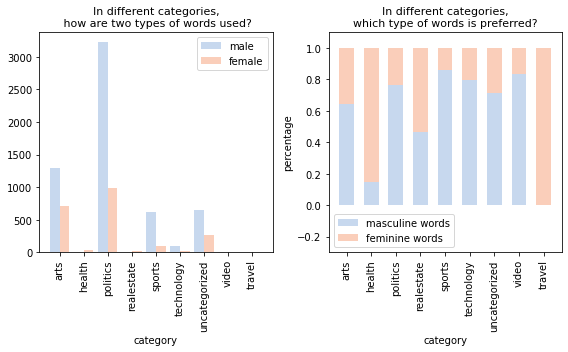

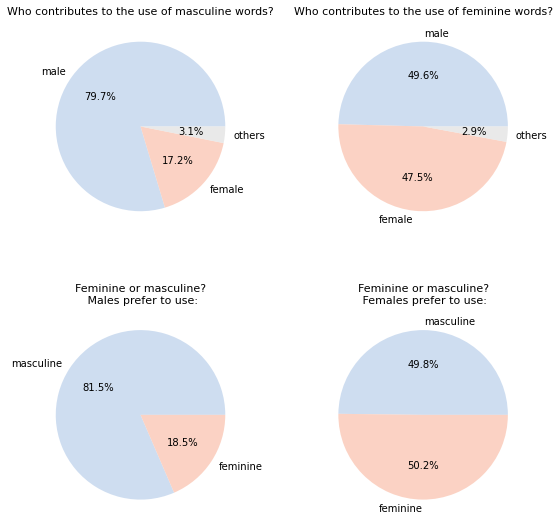

In [6]:
dfs = [df_2015, df_2016, df_2017, df_2018, df_2019, df_2020]
titles = [2015, 2016, 2017, 2018, 2019, 2020]
for i in range(len(dfs)):
  visualization_1(dfs[i], titles[i])

#### **What are the most frequently-used feminine/masculine words?**
Between 2015 and 2020, in the 30 most frequently-used feminine words "witch" ("wizard"), "vagina" ("penis"), "girlfriend" ("boyfriend"), "maiden" ("bachelor"), "spinster" ("bachelor"), "feminism" ("masculism") can't find their masculine-pairs in the 30 most frequently-used masculine words, whereas "god" ("goddess"), "governor" ("governess"), "chairman" ("chairwoman"), "master" ("mistress") can't find their feminine-pairs in the 30 most frequently-used masculine words.

From this word list, we can also discover something interesting if we believe that the more frequently-used words are more representative of the image of a gender in the social media. The most frequently used feminine words including woman, girl, wife, daughter, sister, lady, queen, girlfriend, witch, princess are considered to be the major characters of a female in a society, whereas man, guy, god, father, governor, actors, husband, brother, king, hero, chairman are the main characteristics of a male in a culture.

From these results, we can notice that males are more related to leadership than females in the society because we didn't find "chairwoman", "governess" or "mistress" in the most frequently-used feminine lists. Meanwhile, females may be potentially considered as the accessories of males as "boyfriend", the pair word for "girlfriend", never appears on the most popular masculine list. Comparing the popular titles for males (Mr.) and females (Mrs. and Miss), females still seem to be categorized into married and not married. However, there is less discussion on whether a male is married or not since "spinster" (describing a woman who spins wool for fabric, having long been associated with unattractive old maids), "maiden" (unmarried woman, sometimes refering to an older unmarried woman) are on the most popular feminine wordlist when their masculine word pair "bachelor" is not even though 2 million people are achieving their "bachelor" degrees per year. 

But, there're still encouraging discoveries. Word "feminism" being among the most popular feminine wordlist from 2017 to 2019 indicates the gender inequality is more and more concerned in the recent years. Meanwhile, the elimination of negative feminine words "spinster" and "maiden" from the most popular feminine wordlist is a good sign for the development of social improvement. 

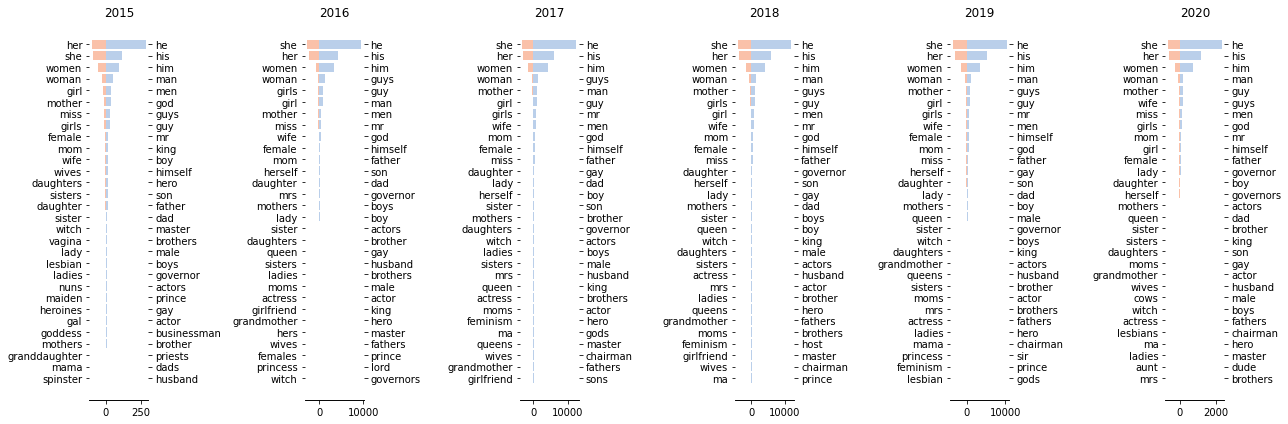

In [7]:
visualization_2(dfs)

### **2.3. Language, Gender, and Partisanship**
The following discovery is enlightened by a relative [research](https://journals.sagepub.com/doi/full/10.1177/1065912919874883) where researches found the Republican Party uses more masculine language than the Democratic Party in their official party platform. The Quotebank dataset provides us an opportunity to verify this statement -**if there really exists a difference between languages used by Republican Party and Democratic Party?**

First, we can take a look at the gender composition on an overall level, we can notice that despite the difference in the sum of word tokens from Democratic Party and Republican Party, the Republican always use masculine words at a higher rate than the Democratic.

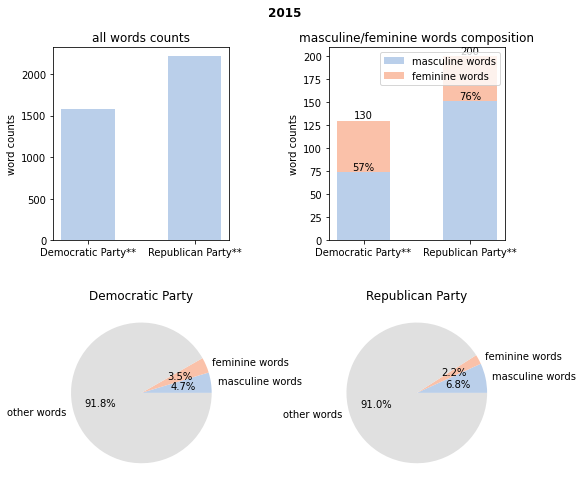

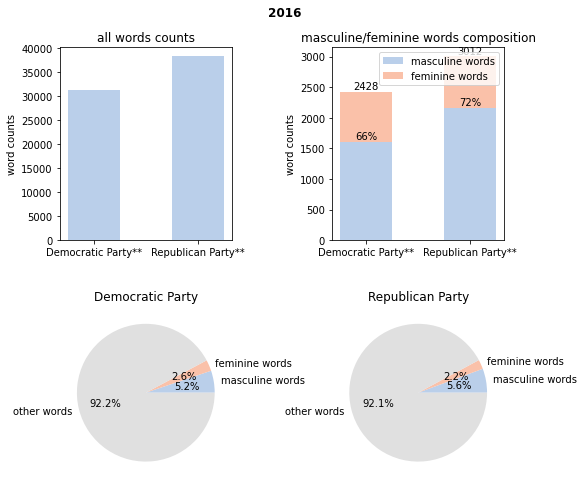

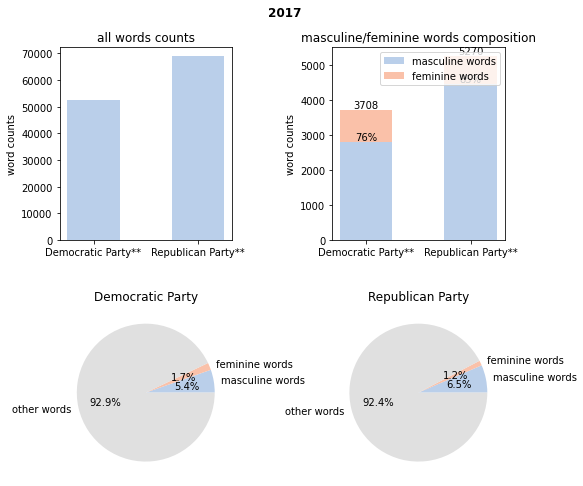

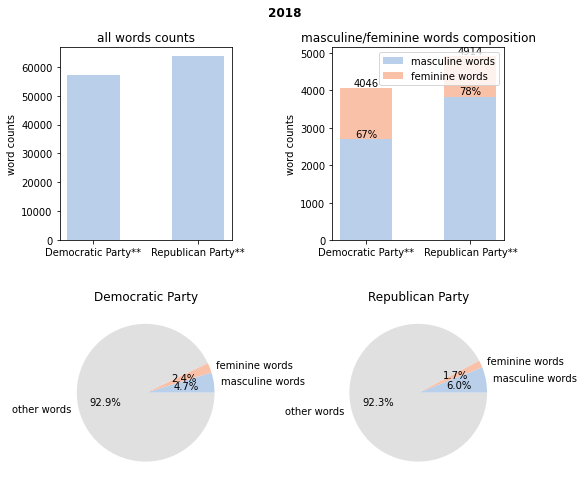

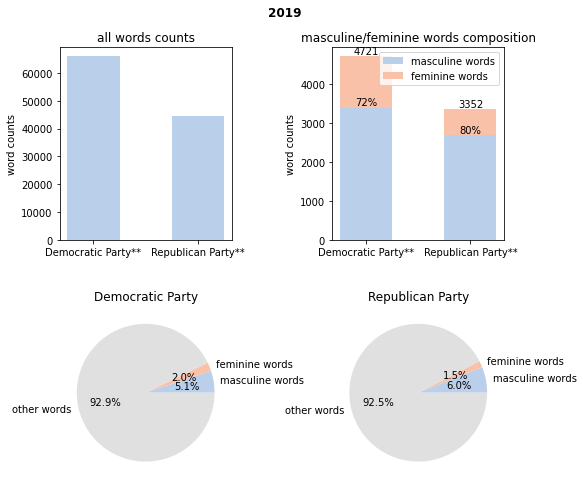

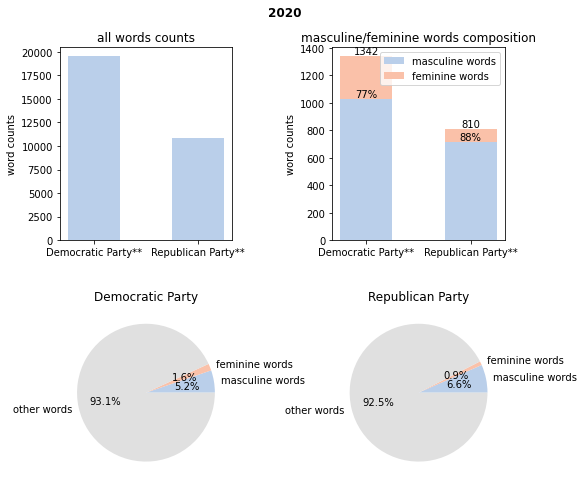

In [8]:
for i in range(len(dfs)):
  visualization_3(dfs[i],titles[i])

#### **How is the speaker composition in two Parties?**
Then, we inspect on how much female speakers and male speakers contribute to feminine words and masculine words usage in two Parties respectively and find out that in Democratic Party, the ratio of female speakers to male speakers is always more balanced than in Republican Party, indicating women have more chance to voice in Democratic Party. Another evidence is that the first woman to win a presidential nomination by a major U.S. political party Hillary Clinton comes from Democratic Party. 

We also find the similar phenomenon that male speakers tend to speak more masculine words than females while female speakers say more feminine words than male speakers in both Parties. In five of six years concerned, both females and males in Democratic Party tend to speak more feminine words than females and males in Republican Party.

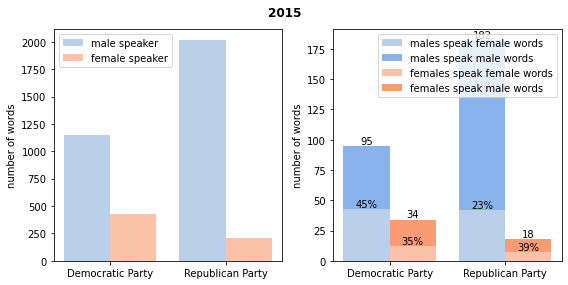

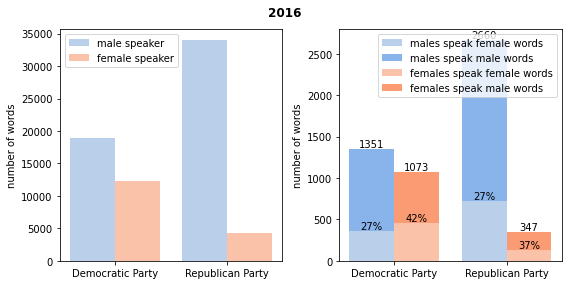

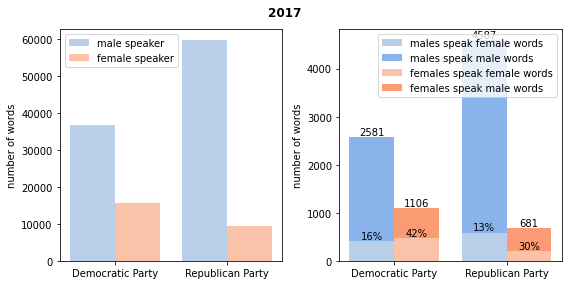

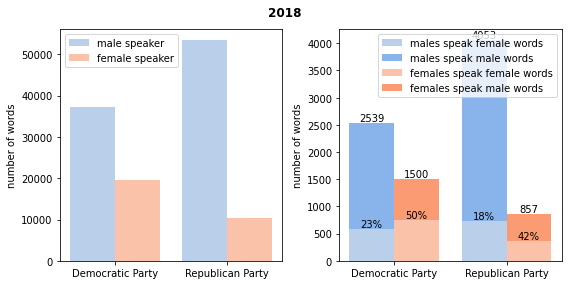

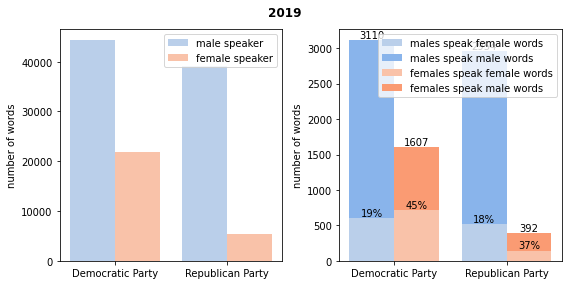

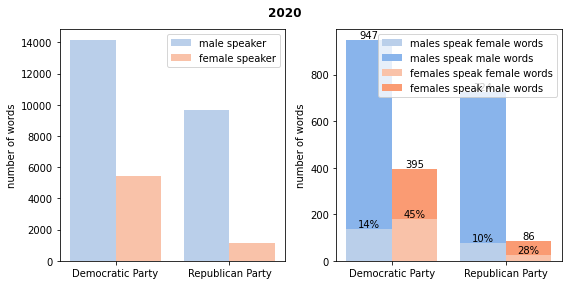

In [9]:
for i in range(len(dfs)):
  visualization_4(dfs[i],titles[i])

#### **How is the gender composition in "the most influential speakers"?**
If we assume that speakers with more spoken words detected are more “influential”, we can then display the gender composition in the 50 "most influential" speakers in Democratic Party and Republican Party. We can notice that though the majority is still male in both Parties, Democratic Party consistently has more female speakers among the top 50 “most influential” speakers.

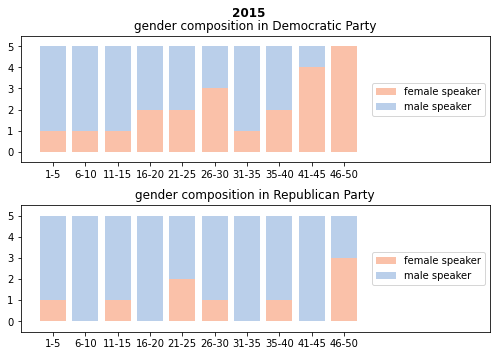

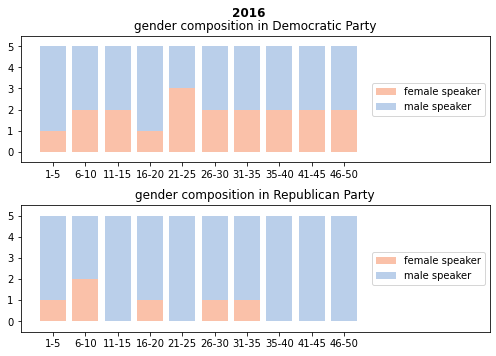

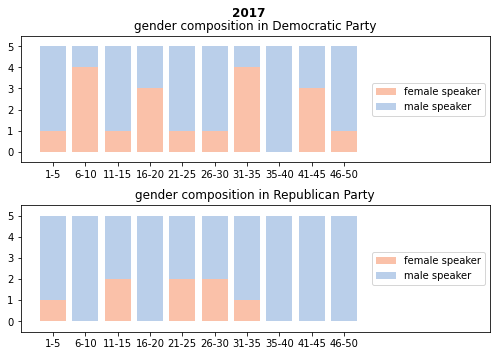

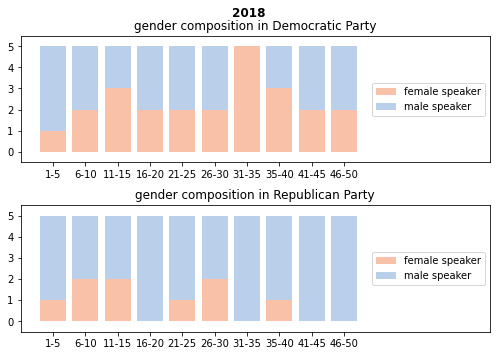

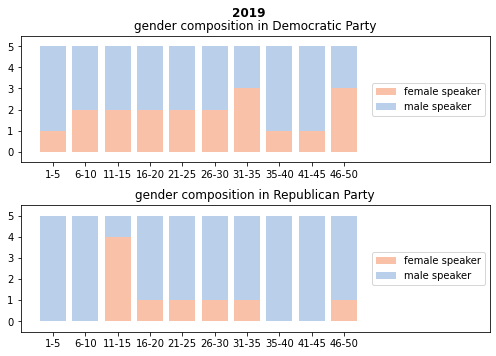

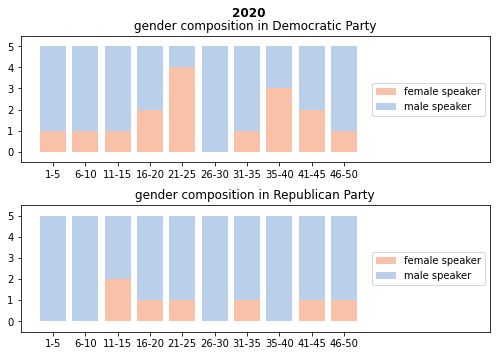

In [10]:
for i in range(len(dfs)):
  visualization_5(dfs[i],titles[i])

##### **Statistical analysis 1:** Compare the gender composition (gender ratio) in the top 50 speakers with most spoken words.

We can examine if the ratio of male speakers to female speakers is statistically different between Democratic Party and Republican Party by t-test. Except for year 2017 (p-value = 0.058), t-test for the other 5 years shows that a statistically difference exists between the male to female ratio between two Parties. 

In [13]:
def statistical_analysis_1(df):
  """
  Compute the p-value on the two distribution.
  """
  df1 = df.query("first_speaker_party == 'Democratic Party**'")
  df2 = df.query("first_speaker_party == 'Republican Party**'")
  _,_, ratio_d = count_speaker_gender(df1)
  _,_, ratio_r = count_speaker_gender(df2)
  _,p_levene = stats.levene(ratio_d,ratio_r)
  if p_levene >0.05:
    print('p-value({}) of levene test is >0.05, indicating no statistically significant evidence shows two distributions have different variances'.format(p_levene))
  else:
    print('p-value({}) of levene test is <0.05, indicating statistically significant evidence shows two distributions have different variances'.format(p_levene))
  # According to the levene result, no statistically significant evidence shows two distributions have different variances.
  _,p_ttest = stats.ttest_ind(ratio_d,ratio_r)
  if p_ttest <0.05:
    print('p-value({}) of t-test is < 0.05, indicating the mean value of two distributions are statistically different.'.format(p_ttest))
  else:
    print('p-value({}) of t-test is > 0.05, indicating no evidence shows the mean value of two distributions are statistically different.'.format(p_ttest))

  # p<0.05 indicates two samples are statistically different at 95% confidence level.

for i in range(len(dfs)):
  print(titles[i])
  statistical_analysis_1(dfs[i])

2015
p-value(0.42395277691927025) of levene test is >0.05, indicating no statistically significant evidence shows two distributions have different variances
p-value(0.02766703937466151) of t-test is < 0.05, indicating the mean value of two distributions are statistically different.
2016
p-value(0.11770150905630472) of levene test is >0.05, indicating no statistically significant evidence shows two distributions have different variances
p-value(0.00024024631448353167) of t-test is < 0.05, indicating the mean value of two distributions are statistically different.
2017
p-value(0.4988298659457183) of levene test is >0.05, indicating no statistically significant evidence shows two distributions have different variances
p-value(0.05771722672432426) of t-test is > 0.05, indicating no evidence shows the mean value of two distributions are statistically different.
2018
p-value(0.7730461433085736) of levene test is >0.05, indicating no statistically significant evidence shows two distributions 

#### **If the results achieved by the paper is also valid in our dataset?**
We introduced the word list with scores on 700 selected words (ranging from 1-7, most feminine - most masculine) and calculated the average score on Republican Party and Democratic Party. We firstly visualized the score distribution in female/male pair groups and Republican Party/Democratic Party pair groups and found that except year 2015, males always have a higher mean score than females. The result is consistent to what we discovered previously that males prefer to use more masculine words than females and thus the average score will be higher (more masculine). Compared to Democratic Party, Republican Party always has a higher average score, suggesting that Republican Party uses more masculine words than Democratic Party. 

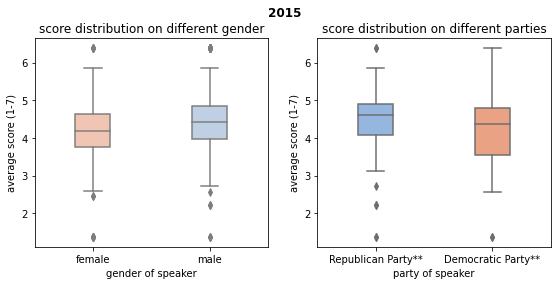

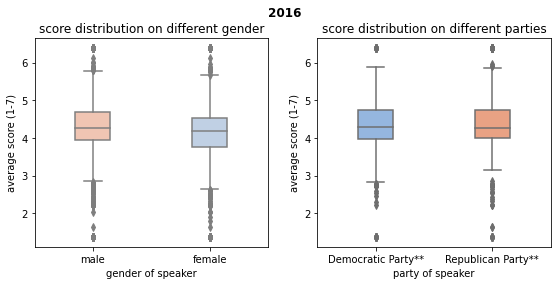

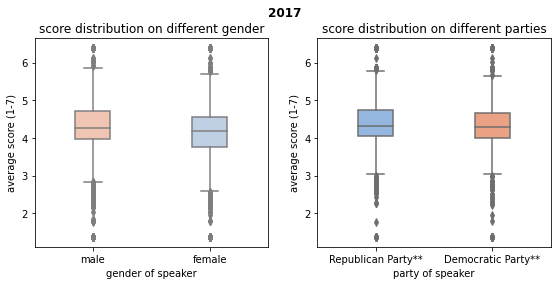

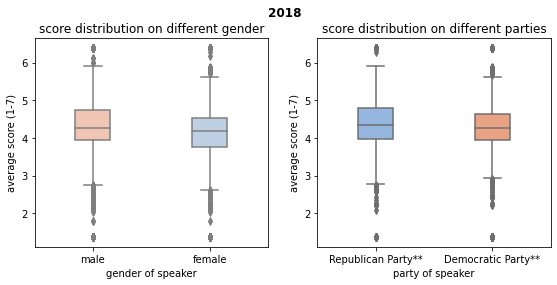

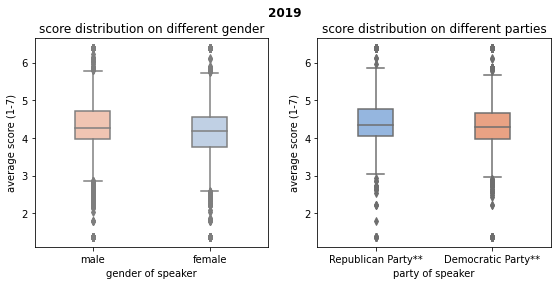

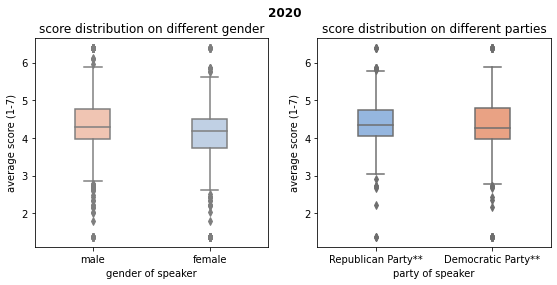

In [14]:
for i in range(len(dfs)):
  visualization_6(dfs[i],titles[i])

##### **Statistical analysis 2:** Compare the mean of scores achieved by Democratic Party and Republican Party.

In [15]:
def statistical_analysis_2(df):
  df = df[df['politician_word_num']!=0].copy()
  df['average_score'] = df['sum_score']/df['politician_word_num']
  df2 = df.query("first_speaker_party == 'Democratic Party**' or first_speaker_party == 'Republican Party**'")
  # perform t-test on different groups
  _, p_levene = stats.levene(df2[df2['first_speaker_party']=='Democratic Party**']['average_score'],df2[df2['first_speaker_party']=='Republican Party**']['average_score'])
  if p_levene > 0.05:
    print('p-value({}) of levene test is >0.05, indicating no statistically significant evidence shows two distributions have different variances'.format(p_levene))
  else:
    print('p-value({}) of levene test is <0.05, indicating statistically significant evidence shows two distributions have different variances'.format(p_levene))
  # According to the levene result, no statistically significant evidence shows two distributions have different variances.
  _, p_ttest = stats.ttest_ind(df2[df2['first_speaker_party']=='Democratic Party**']['average_score'],df2[df2['first_speaker_party']=='Republican Party**']['average_score'])
  if p_ttest < 0.05:
    print('p-value({}) of t-test is < 0.05, indicating the mean values of two distributions are statistically different.'.format(p_ttest))
  else:
    print('p-value({}) of t-test is > 0.05, indicating no evidence shows the mean values of two distributions are statistically different.'.format(p_ttest))

for i in range(len(dfs)):
  print(titles[i])
  statistical_analysis_2(dfs[i])

2015
p-value(0.17559740365803492) of levene test is >0.05, indicating no statistically significant evidence shows two distributions have different variances
p-value(0.4744630733690447) of t-test is > 0.05, indicating no evidence shows the mean values of two distributions are statistically different.
2016
p-value(0.26677313171295186) of levene test is >0.05, indicating no statistically significant evidence shows two distributions have different variances
p-value(0.34884183129659396) of t-test is > 0.05, indicating no evidence shows the mean values of two distributions are statistically different.
2017
p-value(0.7377950078790122) of levene test is >0.05, indicating no statistically significant evidence shows two distributions have different variances
p-value(0.0011800111135578538) of t-test is < 0.05, indicating the mean values of two distributions are statistically different.
2018
p-value(0.6385520579299859) of levene test is >0.05, indicating no statistically significant evidence shows

However, the preliminery conclusion is not statistically proven. After conducting a t-test to compare the scores obtained by speakers from the Republican and Democratic parties, the p-values are smaller than 0.05 in 2017, 2018, 2019, indicating a statistical difference in the use of language between the Democratic and Republican parties in these years at 95% confidence level. However, no evidence shows difference exists in 2015, 2016, 2020. The interesting thing is that the turning point coincides with the presidential change (2017: Barack Obama to Donald Trump) and it’s also pointed out in the research that Donald Trump is regarded as a hyper-masculine politician by some but we still need more evidences to prove it. 